In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

from collections import Counter
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import bottleneck as bn
import requests
import io
from sklearn.linear_model import LinearRegression
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf


# pandas tricks for better display

pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

In [2]:
# covid case data

url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv" 
download = requests.get(url).content
nyt_covid_df = pd.read_csv(io.StringIO(download.decode('utf-8')))
nyt_covid_df = nyt_covid_df.rename(columns={'fips': "FIPS", 'date': 'Date'})
nyt_covid_df = nyt_covid_df[nyt_covid_df['FIPS'].notna()]
nyt_covid_df['FIPS'] = nyt_covid_df['FIPS'].astype(np.int64).astype(str)
nyt_covid_df["new_daily_cases"] = nyt_covid_df.cases - nyt_covid_df.groupby("FIPS").cases.shift(periods=1)
nyt_covid_df['seven_d_avg_cases'] =  nyt_covid_df.groupby('FIPS').new_daily_cases.rolling(7).mean().reset_index(0,drop=True)
nyt_covid_df['Date'] = pd.to_datetime(nyt_covid_df['Date'])
nyt_covid_df['FIPS'] = np.where(nyt_covid_df['FIPS'].str.len()<5,nyt_covid_df['FIPS'].str.zfill(5),nyt_covid_df['FIPS'])
nyt_covid_df['seven_d_avg_week_prior'] = nyt_covid_df.groupby("FIPS").seven_d_avg_cases.shift(periods=7)
nyt_covid_df = nyt_covid_df[['Date','FIPS','deaths','seven_d_avg_week_prior']]

In [3]:
# population data

url = "https://raw.githubusercontent.com/balsama/us_counties_data/main/data/counties.csv" 
download = requests.get(url).content
pop_df = pd.read_csv(io.StringIO(download.decode('utf-8')))
pop_df = pop_df.rename(columns={'FIPS Code': "FIPS"})
pop_df["FIPS"] = pop_df['FIPS'].astype(str)
pop_df = pop_df[["FIPS"]]

In [4]:
# election df

election_df = pd.read_csv('election-context-2018.csv')
election_df['fips'] = election_df.fips.astype(str)
election_df['FIPS'] = np.where(election_df['fips'].str.len()<5,election_df['fips'].str.zfill(5),election_df['fips'])
election_df['median_hh_inc_thousands'] = (election_df['median_hh_inc'] / 1000)
election_df['trump16_mp_share'] = (election_df['trump16'] / (election_df['trump16'] + election_df['clinton16'])) * 100
election_df = election_df[['FIPS', 'total_population', 'trump16_mp_share', 'nonwhite_pct', 'lesscollege_pct', 'age29andunder_pct', 'black_pct', 'hispanic_pct', 'age65andolder_pct', 'median_hh_inc_thousands', 'rural_pct']]


In [5]:
# vax df

vax_df = pd.read_csv('COVID-19_Vaccinations_in_the_United_States_County (1)modified.csv')
vax_df = vax_df[['Date', 'FIPS', 'Recip_County', 'Recip_State', 'Administered_Dose1_Recip']]
vax_df['Date'] = pd.to_datetime(vax_df['Date'])
vax_df = vax_df.sort_values("Date")
vax_df['FIPS'] = np.where(vax_df['FIPS'].str.len()<5,vax_df['FIPS'].str.zfill(5),vax_df['FIPS'])
vax_df['new_daily_first_dose'] = vax_df.Administered_Dose1_Recip - vax_df.groupby("FIPS").Administered_Dose1_Recip.shift(periods=1)
vax_df['seven_d_avg'] =  vax_df.groupby('FIPS')['new_daily_first_dose'].rolling(7).mean().reset_index(0,drop=True)
vax_df['FIPS'] = vax_df['FIPS'].astype(str)


In [6]:

merged_df = vax_df.merge(election_df, on = "FIPS", copy=False).merge(nyt_covid_df, on = ['FIPS', 'Date'])

merged_df['new_vax_doses_per_1k_7d_avg'] = merged_df['seven_d_avg'] / merged_df['total_population'] * 1000
merged_df['cumulative_deaths_per_1000'] = merged_df['deaths'] / merged_df['total_population'] * 1000
merged_df['cases_per_10000_week_prior'] = merged_df['seven_d_avg_week_prior'] / merged_df['total_population'] * 10000
merged_df['pct_vaccinated'] = merged_df['Administered_Dose1_Recip'] / merged_df['total_population'] * 100

merged_df.dtypes

Date                           datetime64[ns]
FIPS                                   object
Recip_County                           object
Recip_State                            object
Administered_Dose1_Recip              float64
new_daily_first_dose                  float64
seven_d_avg                           float64
total_population                      float64
trump16_mp_share                      float64
nonwhite_pct                          float64
lesscollege_pct                       float64
age29andunder_pct                     float64
black_pct                             float64
hispanic_pct                          float64
age65andolder_pct                     float64
median_hh_inc_thousands               float64
rural_pct                             float64
deaths                                float64
seven_d_avg_week_prior                float64
new_vax_doses_per_1k_7d_avg           float64
cumulative_deaths_per_1000            float64
cases_per_10000_week_prior        

In [7]:
#election_df

def county_comparison(treatment_fips, control_fips):

    treatment_stats = merged_df[merged_df['FIPS'] == treatment_fips][['Recip_County', 'Recip_State','FIPS','trump16_mp_share','nonwhite_pct','black_pct','lesscollege_pct','age29andunder_pct','age65andolder_pct','median_hh_inc_thousands','rural_pct']].head(1)
    control_stats = merged_df[merged_df['FIPS'] == control_fips][['Recip_County', 'Recip_State','FIPS','trump16_mp_share','nonwhite_pct','black_pct','lesscollege_pct','age29andunder_pct','age65andolder_pct','median_hh_inc_thousands','rural_pct']].head(1)
   
    treatment_stats['treatment'] = 1
    control_stats['treatment'] = 0
    
    test = pd.concat([treatment_stats, control_stats]).reset_index(drop = True)
    test = test.drop(columns = ["FIPS", "age29andunder_pct"])
    return test
    

In [8]:
list_of_counties = [('36055', '36029'), 
                    ('39095', '39151'),
                    ('41051', '41067'),
                    ('01055', '01015'),
                    ('05143', '05007'),
                    ('37191', '37147'),
                    ('48201', '48113'),
                    ('13245', '13021'),
                    ('13089', '13121'),
                    ('29047', '29095'),
                    ('39061', '39049'),
                    ('45089', '45027'),
                    ('39113', '39017'),
                    ('13095', '13247'),
                    ('13077', '13113'),
                    ('13097', '13067'),
                    ('29189', '29183'),
                    ('13135', '13051'),
                    ('48029', '48439'),                    
                    ('56021', '56025')
]

for i in list_of_counties:

    display(county_comparison(i[0], i[1]))

,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Monroe County,NY,42.003,28.671,14.498,63.335,15.492,53.568,6.450,1
1,Erie County,NY,46.637,23.674,13.020,67.801,16.537,52.744,9.404,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Lucas County,OH,40.582,30.258,18.793,74.910,14.605,42.917,4.66,1
1,Stark County,OH,59.080,12.960,7.191,77.368,17.706,48.714,13.53,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Multnomah County,OR,18.849,28.907,5.281,57.319,11.909,57.449,1.342,1
1,Washington County,OR,35.186,32.251,1.775,58.800,11.834,69.743,5.590,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Etowah County,AL,75.60,21.569,15.285,83.508,17.363,40.478,37.483,1
1,Calhoun County,AL,71.28,27.002,20.332,82.347,15.931,41.954,33.697,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Washington County,AR,55.418,27.636,3.367,68.823,10.727,45.442,25.495,1
1,Benton County,AR,68.490,25.262,1.428,69.277,12.784,59.016,25.160,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Wayne County,NC,55.851,45.725,30.599,81.336,14.362,40.457,46.404,1
1,Pitt County,NC,46.044,44.456,34.178,70.541,11.363,42.308,25.436,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Harris County,TX,43.542,68.814,18.516,69.924,9.220,55.584,1.213,1
1,Dallas County,TX,36.317,69.175,22.063,70.317,9.679,51.411,0.688,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Richmond County,GA,33.382,63.992,55.081,78.956,12.557,38.595,9.216,1
1,Bibb County,GA,39.525,60.144,53.639,75.410,13.935,37.108,14.410,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,DeKalb County,GA,16.995,70.809,53.629,58.255,10.332,52.623,0.263,1
1,Fulton County,GA,28.393,59.742,43.563,50.194,10.394,58.851,1.078,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Clay County,MO,55.921,17.556,5.635,68.124,12.757,63.702,9.816,1
1,Jackson County,MO,56.241,37.334,23.531,70.573,13.546,48.104,3.837,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Hamilton County,OH,44.600,33.645,25.654,64.404,14.162,50.399,2.232,1
1,Franklin County,OH,36.207,34.872,21.423,61.647,10.850,54.037,1.354,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Williamsburg County,SC,32.827,68.796,65.102,87.528,17.754,28.494,81.936,1
1,Clarendon County,SC,48.856,52.781,48.461,85.025,19.820,34.106,85.708,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Montgomery County,OH,50.385,28.315,20.505,73.857,16.633,45.394,4.331,1
1,Butler County,OH,64.592,17.325,7.701,70.866,13.190,59.652,9.343,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Dougherty County,GA,30.504,73.519,68.314,80.234,13.478,33.605,13.960,1
1,Rockdale County,GA,36.692,64.035,49.938,74.039,12.571,51.072,14.933,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Coweta County,GA,71.948,28.227,17.408,71.915,12.468,65.244,32.933,1
1,Fayette County,GA,60.084,34.995,20.742,54.223,16.035,81.689,18.178,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Douglas County,GA,44.457,55.387,42.893,73.852,10.350,57.384,15.757,1
1,Cobb County,GA,48.849,46.179,25.908,55.014,10.583,68.818,0.246,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,St. Louis County,MO,41.386,32.646,23.495,57.618,16.470,61.103,1.138,1
1,St. Charles County,MO,63.933,11.988,4.378,63.854,13.245,75.603,5.830,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Gwinnett County,GA,46.940,59.708,25.436,65.070,8.587,61.865,0.486,1
1,Chatham County,GA,42.312,50.530,39.449,67.105,13.589,49.596,4.505,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Bexar County,TX,42.926,71.112,7.114,73.074,11.255,52.353,4.539,1
1,Tarrant County,TX,54.535,50.810,15.322,69.265,10.216,60.373,1.288,0


,Recip_County,Recip_State,trump16_mp_share,nonwhite_pct,black_pct,lesscollege_pct,age65andolder_pct,median_hh_inc_thousands,rural_pct,treatment
0,Laramie County,WY,68.224,20.976,2.760,72.347,14.121,61.201,19.785,1
1,Natrona County,WY,78.171,12.974,1.159,77.787,12.825,56.983,14.449,0


In [9]:

list_a = [("Monroe County", "Erie County", "NY", datetime.strptime("2021-10-23", "%Y-%m-%d")),
        ("Lucas County", "Stark County", "OH", datetime.strptime("2021-08-07", "%Y-%m-%d")),
        ("Multnomah County", "Washington County", "OR", datetime.strptime("2021-07-22", "%Y-%m-%d")),
        ("Etowah County", "Calhoun County", "AL", datetime.strptime("2021-08-18", "%Y-%m-%d")),
        ("Washington County", "Benton County", "AR", datetime.strptime("2021-09-20", "%Y-%m-%d")),
        ("Wayne County", "Pitt County", "NC", datetime.strptime("2021-08-16", "%Y-%m-%d")),
        ("Harris County", "Dallas County", "TX", datetime.strptime("2021-08-17", "%Y-%m-%d")),
        ("Richmond County", "Bibb County", "GA", datetime.strptime("2021-08-19", "%Y-%m-%d")),
        ("DeKalb County", "Fulton County", "GA", datetime.strptime("2021-09-08", "%Y-%m-%d")),
        ("Clay County", "Jackson County", "MO", datetime.strptime("2021-10-05", "%Y-%m-%d")),
        ("Hamilton County", "Franklin County", "OH", datetime.strptime("2021-08-24", "%Y-%m-%d")),
        ("Williamsburg County", "Clarendon County", "SC", datetime.strptime("2021-08-25", "%Y-%m-%d")),
        ("Montgomery County", "Butler County", "OH", datetime.strptime("2021-09-08", "%Y-%m-%d")),
        ("Dougherty County", "Rockdale County", "GA", datetime.strptime("2021-09-18", "%Y-%m-%d")),
        ("Coweta County", "Fayette County", "GA", datetime.strptime("2021-09-16", "%Y-%m-%d")),
        ("Douglas County", "Cobb County", "GA", datetime.strptime("2021-09-18", "%Y-%m-%d")),
        ("St. Louis County", "St. Charles County", "MO", datetime.strptime("2021-09-22", "%Y-%m-%d")),
        ("Gwinnett County", "Chatham County", "GA", datetime.strptime("2021-10-22", "%Y-%m-%d")),
        ("Bexar County", "Tarrant County", "TX", datetime.strptime("2021-09-24", "%Y-%m-%d")),
        ("Laramie County", "Natrona County", "WY", datetime.strptime("2021-09-13", "%Y-%m-%d")),
        ]

num_comparisons = np.arange(0, len(list_a), 1)

upper = 14
lower = -16

# upper = 29
# lower = -31

# upper = 7
# lower = -9


<ipython-input-10-9b93bedce103>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['days_since_intervention'] = (merged_df['Date'] - list_a[i][3]).dt.days
<ipython-input-10-9b93bedce103>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['days_since_intervention'] = (merged_df['Date'] - list_a[i][3]).dt.days
<ipython-input-10-9b93bedce103>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

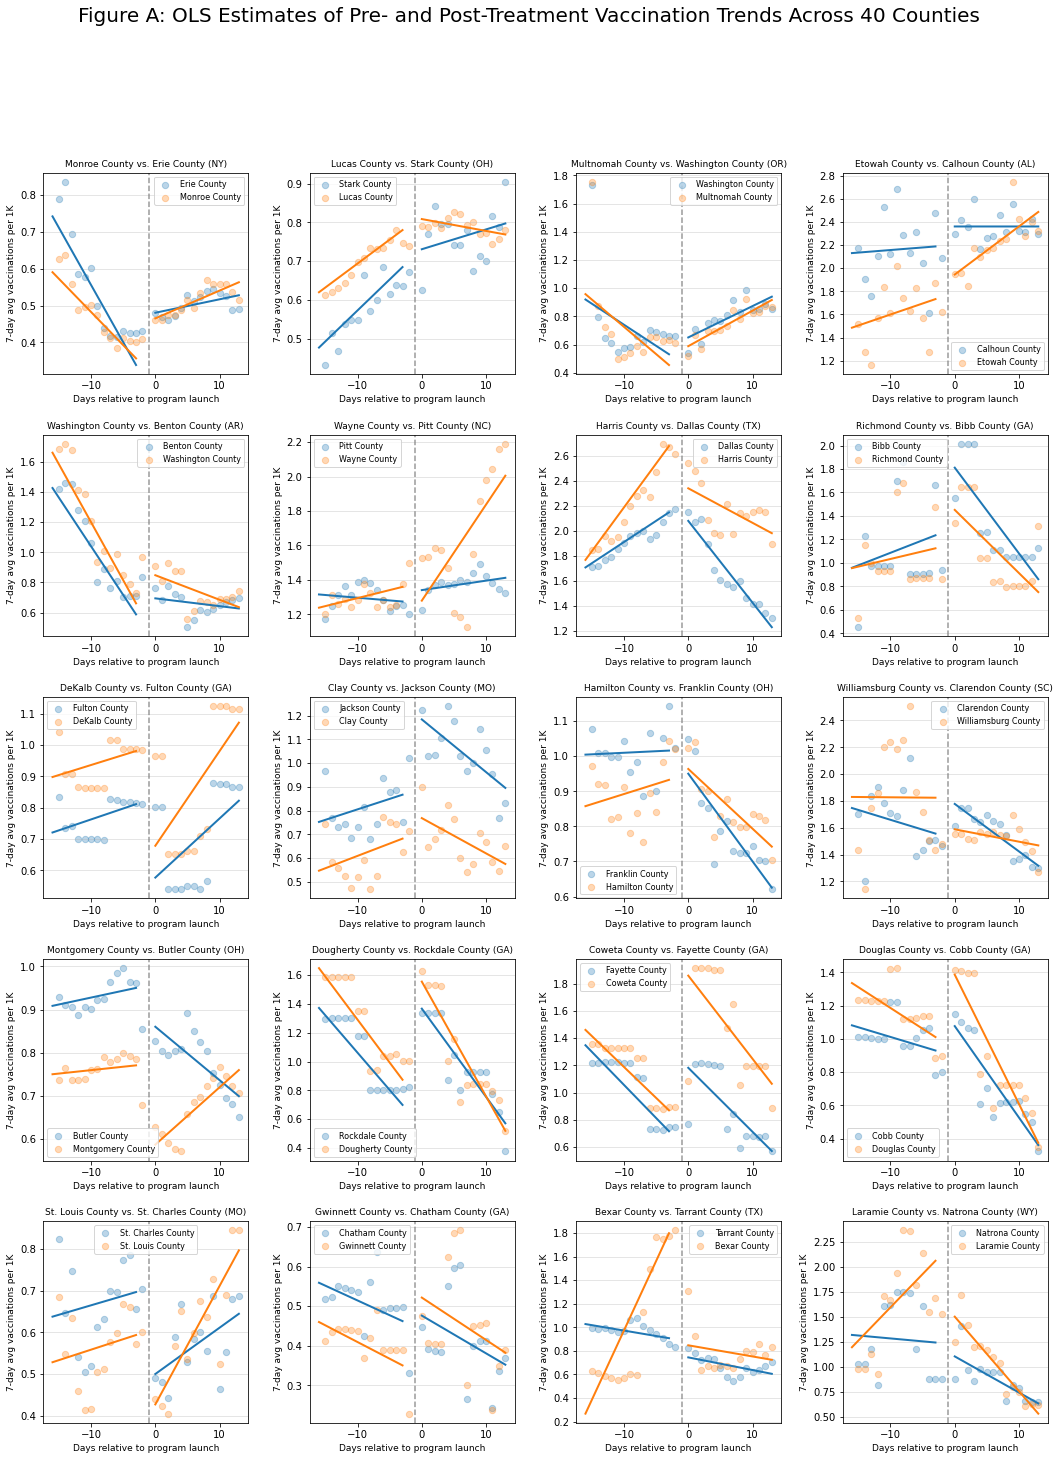

In [10]:

real_df = pd.DataFrame()

for i in num_comparisons:    
    
    df2 =  merged_df[((merged_df['Recip_County'] == list_a[i][0]) | (merged_df['Recip_County'] == list_a[i][1])) & (merged_df['Recip_State'] == list_a[i][2])]
    df2['days_since_intervention'] = (merged_df['Date'] - list_a[i][3]).dt.days
    df2 = df2[(df2['days_since_intervention'] > lower) & (df2['days_since_intervention'] < upper)]
    df2['figure'] = i
    df2['post_launch'] = np.where((df2['days_since_intervention']) > -1, 1, 0)
    df2 = df2[df2['days_since_intervention'] != -1]
    df2['treatment'] = np.where((df2['Recip_County'] == list_a[i][0]), 1, 0)

    real_df = real_df.append(df2)

fig, axes = plt.subplots(5,4,figsize=(18,23))
axes = axes.ravel()
fig.subplots_adjust(hspace = .3, wspace=.3)

for i in num_comparisons:

    smaller_df = real_df[real_df['figure'] == i]

#    display(smaller_df.head())
    m, b = np.polyfit(smaller_df['days_since_intervention'][smaller_df['treatment'] == 0][smaller_df['post_launch'] == 1], smaller_df['new_vax_doses_per_1k_7d_avg'][smaller_df['treatment'] == 0][smaller_df['post_launch'] == 1], 1)   
    axes[i].plot(np.arange(0, upper, 1), m*smaller_df['days_since_intervention'][smaller_df['treatment'] == 0][smaller_df['post_launch'] == 1]+b, lw = 2, color = "tab:blue")

    m, b = np.polyfit(smaller_df['days_since_intervention'][smaller_df['treatment'] == 0][smaller_df['post_launch'] == 0], smaller_df['new_vax_doses_per_1k_7d_avg'][smaller_df['treatment'] == 0][smaller_df['post_launch'] == 0], 1)   
    axes[i].plot(np.arange(lower, -2, 1), m*smaller_df['days_since_intervention'][smaller_df['treatment'] == 0][smaller_df['post_launch'] == 0]+b, lw = 2, color = "tab:blue")
    
    m, b = np.polyfit(smaller_df['days_since_intervention'][smaller_df['treatment'] == 1][smaller_df['post_launch'] == 1], smaller_df['new_vax_doses_per_1k_7d_avg'][smaller_df['treatment'] == 1][smaller_df['post_launch'] == 1], 1)   
    axes[i].plot(np.arange(0, upper, 1), m*smaller_df['days_since_intervention'][smaller_df['treatment'] == 1][smaller_df['post_launch'] == 1]+b, lw = 2, color = "tab:orange")
   
    m, b = np.polyfit(smaller_df['days_since_intervention'][smaller_df['treatment'] == 1][smaller_df['post_launch'] == 0], smaller_df['new_vax_doses_per_1k_7d_avg'][smaller_df['treatment'] == 1][smaller_df['post_launch'] == 0], 1)   
    axes[i].plot(np.arange(lower, -2, 1), m*smaller_df['days_since_intervention'][smaller_df['treatment'] == 1][smaller_df['post_launch'] == 0]+b, lw = 2, color = "tab:orange")


    axes[i].scatter(smaller_df['days_since_intervention'][smaller_df['treatment'] == 0],smaller_df['new_vax_doses_per_1k_7d_avg'][smaller_df['treatment'] == 0], 
                    alpha = 0.3, label = smaller_df['Recip_County'][smaller_df['treatment'] == 0].iloc[0],
                    s = 40)

    axes[i].scatter(smaller_df['days_since_intervention'][smaller_df['treatment'] == 1],smaller_df['new_vax_doses_per_1k_7d_avg'][smaller_df['treatment'] == 1], 
                    alpha = 0.3, label = smaller_df['Recip_County'][smaller_df['treatment'] == 1].iloc[0],
                    s = 40)

    axes[i].set_ylabel('7-day avg vaccinations per 1K', fontsize = 9)
    axes[i].set_xlabel('Days relative to program launch', fontsize = 9)

    axes[i].set_title(f"{smaller_df['Recip_County'][smaller_df['treatment'] == 1].iloc[0]} vs. {smaller_df['Recip_County'][smaller_df['treatment'] == 0].iloc[0]} ({smaller_df['Recip_State'][smaller_df['treatment'] == 1].iloc[0]})", fontsize=9)
    axes[i].grid(":", axis = 'y', alpha=0.4)
    axes[i].axvline(x = -1, alpha = 0.8, color = "gray", linestyle = "--")
    axes[i].legend(fontsize = 8)
    fig.suptitle("Figure A: OLS Estimates of Pre- and Post-Treatment Vaccination Trends Across 40 Counties", fontsize = 20)
    
fig.savefig('figure_A.png', dpi=200)



In [11]:
# reducing dataset to n=18

list_a = [("Monroe County", "Erie County", "NY", datetime.strptime("2021-10-23", "%Y-%m-%d")),
        ("Lucas County", "Stark County", "OH", datetime.strptime("2021-08-07", "%Y-%m-%d")),
        ("Multnomah County", "Washington County", "OR", datetime.strptime("2021-07-22", "%Y-%m-%d")),
        ("Etowah County", "Calhoun County", "AL", datetime.strptime("2021-08-18", "%Y-%m-%d")),
        ("Washington County", "Benton County", "AR", datetime.strptime("2021-09-20", "%Y-%m-%d")),
        ("Wayne County", "Pitt County", "NC", datetime.strptime("2021-08-16", "%Y-%m-%d")),
        ("Harris County", "Dallas County", "TX", datetime.strptime("2021-08-17", "%Y-%m-%d")),
        ("Richmond County", "Bibb County", "GA", datetime.strptime("2021-08-19", "%Y-%m-%d")),
        ("DeKalb County", "Fulton County", "GA", datetime.strptime("2021-09-08", "%Y-%m-%d")),
        ("Clay County", "Jackson County", "MO", datetime.strptime("2021-10-05", "%Y-%m-%d")),
        ("Hamilton County", "Franklin County", "OH", datetime.strptime("2021-08-24", "%Y-%m-%d")),
        ("Williamsburg County", "Clarendon County", "SC", datetime.strptime("2021-08-25", "%Y-%m-%d")),
        ("Montgomery County", "Butler County", "OH", datetime.strptime("2021-09-08", "%Y-%m-%d")),
        ("Dougherty County", "Rockdale County", "GA", datetime.strptime("2021-09-18", "%Y-%m-%d")),
        ("Coweta County", "Fayette County", "GA", datetime.strptime("2021-09-16", "%Y-%m-%d")),
        ("Douglas County", "Cobb County", "GA", datetime.strptime("2021-09-18", "%Y-%m-%d")),
        ("St. Louis County", "St. Charles County", "MO", datetime.strptime("2021-09-22", "%Y-%m-%d")),
        ("Gwinnett County", "Chatham County", "GA", datetime.strptime("2021-10-22", "%Y-%m-%d")),
     #   ("Bexar County", "Tarrant County", "TX", datetime.strptime("2021-09-24", "%Y-%m-%d")),
     #   ("Laramie County", "Natrona County", "WY", datetime.strptime("2021-09-13", "%Y-%m-%d")),
        ]

num_comparisons = np.arange(0, len(list_a), 1)

real_df = pd.DataFrame()

for i in num_comparisons:    
    
    df2 =  merged_df[((merged_df['Recip_County'] == list_a[i][0]) | (merged_df['Recip_County'] == list_a[i][1])) & (merged_df['Recip_State'] == list_a[i][2])]
    df2['days_since_intervention'] = (merged_df['Date'] - list_a[i][3]).dt.days
    df2 = df2[(df2['days_since_intervention'] > lower) & (df2['days_since_intervention'] < upper)]
    df2['figure'] = i
    df2['post_launch'] = np.where((df2['days_since_intervention']) > -1, 1, 0)
    df2 = df2[df2['days_since_intervention'] != -1]
    df2['treatment'] = np.where((df2['Recip_County'] == list_a[i][0]), 1, 0)

    real_df = real_df.append(df2)

<ipython-input-11-1667c74067a2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['days_since_intervention'] = (merged_df['Date'] - list_a[i][3]).dt.days
<ipython-input-11-1667c74067a2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['days_since_intervention'] = (merged_df['Date'] - list_a[i][3]).dt.days
<ipython-input-11-1667c74067a2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [12]:
list_of_ols_vars = 'new_vax_doses_per_1k_7d_avg ~ treatment * post_launch + black_pct + hispanic_pct + lesscollege_pct + age65andolder_pct + rural_pct + median_hh_inc_thousands + pct_vaccinated + cumulative_deaths_per_1000 + cases_per_10000_week_prior'

model_1 = smf.ols(formula=list_of_ols_vars, data=real_df)

result_1 = model_1.fit()
print(result_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     new_vax_doses_per_1k_7d_avg   R-squared:                       0.563
Model:                                     OLS   Adj. R-squared:                  0.558
Method:                          Least Squares   F-statistic:                     106.8
Date:                         Tue, 14 Dec 2021   Prob (F-statistic):          2.08e-169
Time:                                 04:25:34   Log-Likelihood:                -351.03
No. Observations:                         1008   AIC:                             728.1
Df Residuals:                              995   BIC:                             792.0
Df Model:                                   12                                         
Covariance Type:                     nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [13]:
pre_treatment_baseline_daily_vax_rate_per_1000 = real_df[real_df['post_launch'] == 0].new_vax_doses_per_1k_7d_avg.mean()

pre_treatment_baseline_daily_vax_rate_per_1000

coefficient = 0.0862

(coefficient / pre_treatment_baseline_daily_vax_rate_per_1000) * 100

pre_treatment_baseline_daily_vax_rate_per_1000

1.0433065418193754

5 counties had statistically significant positive DID estimators and 3 counties had statistically significant negative DID estimators.


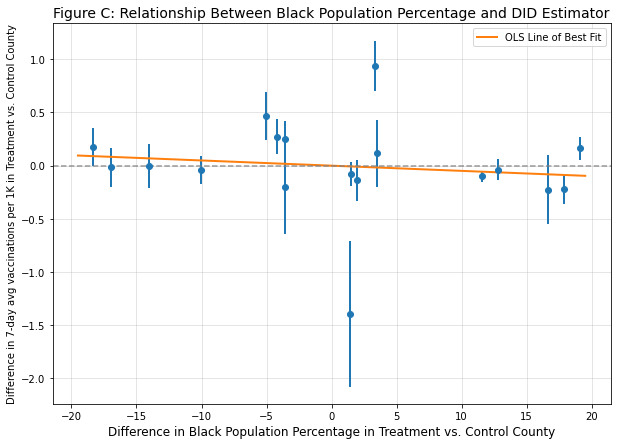

In [14]:
counties_coefficients, counties_p_vals, read_df_lower_bound_list, read_df_upper_bound_list, black_pct_list = [], [], [], [], []

for i in num_comparisons:

    smaller_df = real_df[real_df['figure'] == i]
    
    model_8 = smf.ols(formula=list_of_ols_vars, data=smaller_df)

    result_8 = model_8.fit()
    
    black_pct_val = smaller_df[27:29]

    black_pct_val_1 = black_pct_val['black_pct'].iloc[0]
    black_pct_val_2 = black_pct_val['black_pct'].iloc[1]

    black_pct_val = black_pct_val_1 - black_pct_val_2
#     print(" ")
#     print(np.unique(smaller_df['Recip_County']))
#     print(" ")
   # print(result_2.summary())
    
    counties_coefficients.append(result_8.params[3])
    counties_p_vals.append(result_8.pvalues[3])
    read_df_lower_bound_list.append(result_8.conf_int()[0][3])
    read_df_upper_bound_list.append(result_8.conf_int()[1][3])
    black_pct_list.append(black_pct_val)

                                 
output_df = pd.DataFrame(zip(counties_coefficients, counties_p_vals, read_df_lower_bound_list, read_df_upper_bound_list, black_pct_list))




good_df = output_df[(output_df[0] > 0) & (output_df[1] < 0.05)]

bad_df = output_df[(output_df[0] < 0) & (output_df[1] < 0.05)]

num_stat_sig_pos = len(good_df)

num_stat_sig_neg = len(bad_df)

print(f"{num_stat_sig_pos} counties had statistically significant positive DID estimators and {num_stat_sig_neg} counties had statistically significant negative DID estimators.")

output_df = output_df.rename(columns = {0:'coefficient', 1:'p_val', 2:'lower', 3:'upper', 4:"black_pct"})

output_df = output_df.sort_values(by = "black_pct")

Y_error = [output_df['coefficient'] - output_df['lower'], (output_df['upper'] - output_df['coefficient'])]

fig, axes = plt.subplots(1,1,figsize=(10,7))

# plt.fill_between(output_df['black_pct'], output_df['lower'], output_df['upper'], alpha = 0.3, color='tab:blue', label="95% CI", interpolate = True)

#m, b = np.polyfit(output_df['black_pct'], output_df['coefficient'], 1)   
#plt.plot(np.arange(output_df['black_pct'].min(), output_df['black_pct'].max(), 1), m*output_df['black_pct']+b, color = "blue")


plt.errorbar(output_df['black_pct'], output_df['coefficient'], color = "tab:blue", lw = 2, yerr= Y_error, fmt="o")

x = np.linspace(-19.5,19.5,100)
y = -0.0049 *x - 0.001

plt.plot(x, y, color = "tab:orange", lw = 2,  label='OLS Line of Best Fit')

#plt.plot(output_df['black_pct'],output_df['coefficient'], color='red', label="Estimate")

# # label plot
plt.ylabel("Difference in 7-day avg vaccinations per 1K in Treatment vs. Control County")
plt.xlabel("Difference in Black Population Percentage in Treatment vs. Control County", fontsize = 12)
plt.title("Figure C: Relationship Between Black Population Percentage and DID Estimator", fontsize = 14)
plt.legend()
plt.grid(":", axis ='x', alpha=0.4)
plt.grid(":", axis ='y', alpha=0.4)
plt.axhline(y = 0, alpha = 0.8, color = "gray", linestyle = "--")
plt.show()

fig.savefig('figure_C.png', dpi=200)



<ipython-input-15-c25fc84ddf2f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['days_since_intervention'] = (merged_df['Date'] - list_a[i][3]).dt.days
<ipython-input-15-c25fc84ddf2f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['days_since_intervention'] = (merged_df['Date'] - list_a[i][3]).dt.days
<ipython-input-15-c25fc84ddf2f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

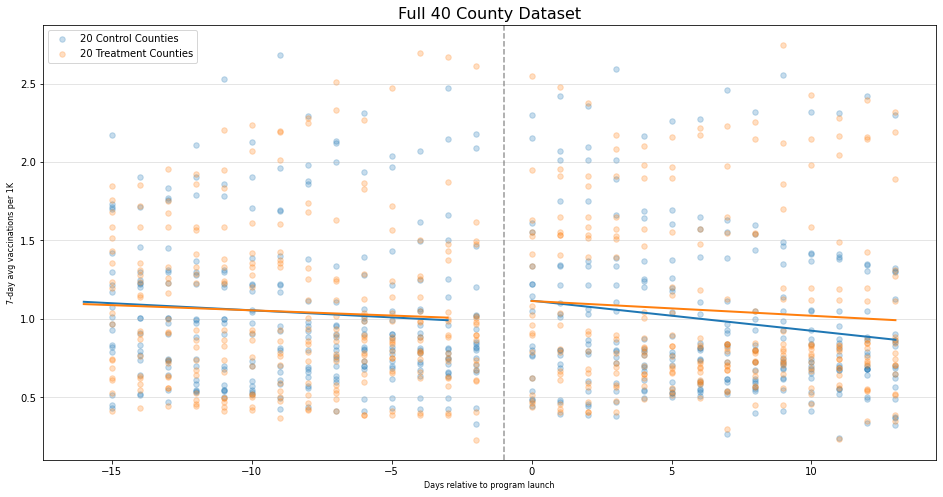

In [15]:

real_df = pd.DataFrame()

for i in num_comparisons:    
    
    df2 =  merged_df[((merged_df['Recip_County'] == list_a[i][0]) | (merged_df['Recip_County'] == list_a[i][1])) & (merged_df['Recip_State'] == list_a[i][2])]
    df2['days_since_intervention'] = (merged_df['Date'] - list_a[i][3]).dt.days
    df2 = df2[(df2['days_since_intervention'] > lower) & (df2['days_since_intervention'] < upper)]
    df2['figure'] = i
    df2['post_launch'] = np.where((df2['days_since_intervention']) > -1, 1, 0)
    df2 = df2[df2['days_since_intervention'] != -1]
    df2['treatment'] = np.where((df2['Recip_County'] == list_a[i][0]), 1, 0)

    real_df = real_df.append(df2)

fig, axes = plt.subplots(1,1,figsize=(16,8))
#axes = axes.ravel()
#fig.subplots_adjust(hspace = .4, wspace=.4)

m, b = np.polyfit(real_df['days_since_intervention'][real_df['treatment'] == 0][real_df['post_launch'] == 1], real_df['new_vax_doses_per_1k_7d_avg'][real_df['treatment'] == 0][real_df['post_launch'] == 1], 1)   
plt.plot(np.arange(0, upper, 1), m*np.arange(0, upper, 1)+b, lw = 2, color = "tab:blue")

m, b = np.polyfit(real_df['days_since_intervention'][real_df['treatment'] == 1][real_df['post_launch'] == 1], real_df['new_vax_doses_per_1k_7d_avg'][real_df['treatment'] == 1][real_df['post_launch'] == 1], 1)   
plt.plot(np.arange(0, upper, 1), m*np.arange(0, upper, 1)+b, lw = 2, color = "tab:orange")

m, b = np.polyfit(real_df['days_since_intervention'][real_df['treatment'] == 0][real_df['post_launch'] == 0], real_df['new_vax_doses_per_1k_7d_avg'][real_df['treatment'] == 0][real_df['post_launch'] == 0], 1)   
plt.plot(np.arange(lower, -2, 1), m*np.arange(lower, -2, 1)+b, lw = 2, color = "tab:blue")
   
m, b = np.polyfit(real_df['days_since_intervention'][real_df['treatment'] == 1][real_df['post_launch'] == 0], real_df['new_vax_doses_per_1k_7d_avg'][real_df['treatment'] == 1][real_df['post_launch'] == 0], 1)   
plt.plot(np.arange(lower, -2, 1), m*np.arange(lower, -2, 1)+b, lw = 2, color = "tab:orange")

plt.scatter(real_df['days_since_intervention'][real_df['treatment'] == 0],real_df['new_vax_doses_per_1k_7d_avg'][real_df['treatment'] == 0], 
                    alpha = 0.25, label = '20 Control Counties',
                    s = 30)

plt.scatter(real_df['days_since_intervention'][real_df['treatment'] == 1],real_df['new_vax_doses_per_1k_7d_avg'][real_df['treatment'] == 1], 
                    alpha = 0.25, label = '20 Treatment Counties',
                    s = 30)

plt.ylabel('7-day avg vaccinations per 1K', fontsize = 8)
plt.xlabel('Days relative to program launch', fontsize = 8)

plt.title(f"Full 40 County Dataset", fontsize=16)
plt.grid(":", axis = 'y', alpha=0.4)
plt.axvline(x = -1, alpha = 0.8, color = "gray", linestyle = "--")
plt.legend()

In [16]:
# black interaction ols

model_4 = smf.ols(formula='new_vax_doses_per_1k_7d_avg ~ treatment * post_launch + (treatment * post_launch) * black_pct + black_pct + hispanic_pct + lesscollege_pct + age65andolder_pct + rural_pct + median_hh_inc_thousands + pct_vaccinated + cumulative_deaths_per_1000 + cases_per_10000_week_prior', data=real_df)

result_4 = model_4.fit()
print(result_4.summary())

                                 OLS Regression Results                                
Dep. Variable:     new_vax_doses_per_1k_7d_avg   R-squared:                       0.571
Model:                                     OLS   Adj. R-squared:                  0.565
Method:                          Least Squares   F-statistic:                     88.14
Date:                         Tue, 14 Dec 2021   Prob (F-statistic):          1.69e-170
Time:                                 04:25:39   Log-Likelihood:                -341.32
No. Observations:                         1008   AIC:                             714.6
Df Residuals:                              992   BIC:                             793.3
Df Model:                                   15                                         
Covariance Type:                     nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [17]:
# hispanic interaction ols

model_5 = smf.ols(formula='new_vax_doses_per_1k_7d_avg ~ treatment * post_launch + (treatment * post_launch) * hispanic_pct + hispanic_pct + black_pct + lesscollege_pct + age65andolder_pct + rural_pct + median_hh_inc_thousands + pct_vaccinated + cumulative_deaths_per_1000 + cases_per_10000_week_prior', data=real_df)

result_5 = model_5.fit()
print(result_5.summary())

                                 OLS Regression Results                                
Dep. Variable:     new_vax_doses_per_1k_7d_avg   R-squared:                       0.566
Model:                                     OLS   Adj. R-squared:                  0.560
Method:                          Least Squares   F-statistic:                     86.28
Date:                         Tue, 14 Dec 2021   Prob (F-statistic):          6.55e-168
Time:                                 04:25:39   Log-Likelihood:                -347.44
No. Observations:                         1008   AIC:                             726.9
Df Residuals:                              992   BIC:                             805.5
Df Model:                                   15                                         
Covariance Type:                     nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------

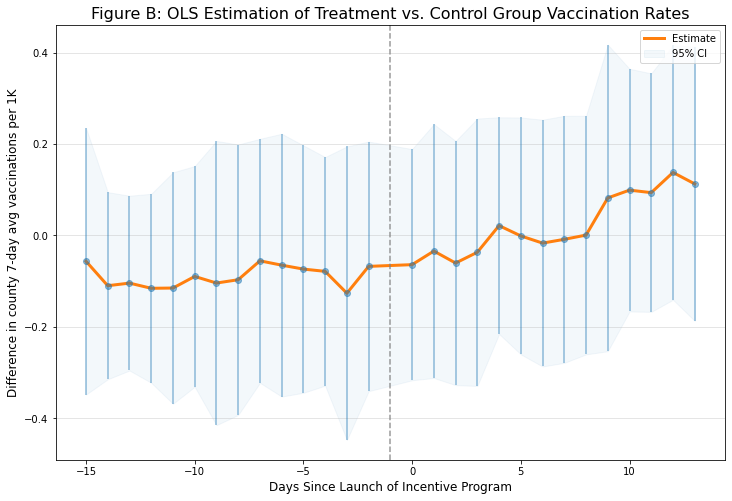

In [18]:
day_list = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

point_list, lower_bound_list, upper_bound_list = [], [], []

for i in day_list:
    
    small_df = real_df[real_df['days_since_intervention'] == i]
    
  #  print(small_df)

    model_3 = smf.ols(formula='new_vax_doses_per_1k_7d_avg ~ treatment + black_pct + hispanic_pct + lesscollege_pct + age65andolder_pct + rural_pct + median_hh_inc_thousands + pct_vaccinated + cumulative_deaths_per_1000 + cases_per_10000_week_prior', data=small_df)

 #   model_3 = smf.ols(formula='new_vax_doses_per_1k_7d_avg ~ treatment + black_pct + hispanic_pct + lesscollege_pct + age65andolder_pct + pct_vaccinated + rural_pct + median_hh_inc_thousands', data=small_df)
    
    result_3 = model_3.fit()
#    print(result_3.summary())
    point_list.append(result_3.params[1])
    lower_bound_list.append(result_3.conf_int()[0][1])
    upper_bound_list.append(result_3.conf_int()[1][1])
    

if_helpful_df = pd.DataFrame(zip(day_list, point_list, lower_bound_list, upper_bound_list))

fig, axes = plt.subplots(1,1,figsize=(12,8))

plt.fill_between(day_list, upper_bound_list, lower_bound_list, alpha = 0.05, color='tab:blue'
                 , label="95% CI"
                )

y_error = [(if_helpful_df[1] - if_helpful_df[2]), (if_helpful_df[3] - if_helpful_df[1])]

plt.errorbar(if_helpful_df[0], if_helpful_df[1], yerr= y_error, color = 'tab:blue', fmt="o", linestyle = '', alpha = 0.5)

plt.plot(day_list,point_list, color='tab:orange', lw = 3, label="Estimate")

# label plot
plt.ylabel("Difference in county 7-day avg vaccinations per 1K", fontsize=12)
plt.xlabel("Days Since Launch of Incentive Program", fontsize=12)
plt.title("Figure B: OLS Estimation of Treatment vs. Control Group Vaccination Rates", fontsize=16)
plt.legend()
plt.grid(":", axis = 'y', alpha=0.4)
plt.axvline(x = -1, alpha = 0.8, color = "gray", linestyle = "--")
plt.show()

fig.savefig('figure_B.png', dpi=200)

